## Goal: How many unique transcripts do we add for each additional sample? 
* also split by all and novel
* somewhere should color / order by population?  ideally would see jumps @ each pop transition
* also should order by total uniq

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import yaml
from snakemake.io import expand
import pyranges as pr
from pyfaidx import Fasta
from mizani.formatters import percent_format
from scipy import stats


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

from plotnine import *

In [131]:
def my_theme(base_size=11, w=4, h=3):
    """
    Custom plotnine theme with:
    - White background
    - Clean styling
    - Axes and ticks retained

    Parameters:
    - base_size: Base font size

    Returns:
    - plotnine.theme object
    """
    return (
        theme_minimal(base_size=base_size)
        + theme(
            # White background
            panel_background=element_rect(fill='white', color=None),
            plot_background=element_rect(fill='white', color=None),

            # Remove grid lines
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),

            # Keep axis lines & ticks (don't blank them)
            axis_line=element_line(color='black'),
            axis_ticks=element_line(color='black'),

            plot_title=element_text(hjust=0.5, family='Helvetica'),
            axis_title_x=element_text(hjust=0.5, family='Helvetica'),
            axis_title_y=element_text(hjust=0.5, margin={'t':0, 'r':-2, 'b':0, 'l':0}, family='Helvetica'),
            
            # Styling text
            legend_title=element_blank(),
            axis_title=element_text(size=base_size + 1, family='Helvetica'),
            legend_text=element_text(size=base_size-2, family='Helvetica'),
            axis_text=element_text(size=base_size, color='black', family='Helvetica'),
            strip_text_x=element_text(size=base_size-1),
            strip_text_y=element_text(size=base_size-1),
            figure_size=(w, h),  # Controls plot dimensions (width x height in inches)
            plot_margin=0.05      # Shrinks surrounding white space
        )
    )

def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

In [3]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [4]:
df = load_meta()
df = df.loc[~df['sample'].str.contains('_')]
df['lab_sample'] = df['lab_number_sample'].astype(str)+'_'+\
                      df['lab_sampleid'].astype(str)+'_'+\
                      df['cell_line_id'].astype(str)
df.columns
df = df[['cell_line_id', 'sample', 'hapmap_DNA_ID',
          'map_reads_assemblymap','lab_sample', 'population']].drop_duplicates()

temp_df = pd.read_csv('../snakemake/transcript_discovery_personal/cell_line_ids.txt', header=None, names=['cell_line_id'])

# make a 1000g cell line id col
df['cell_line_id_1000g'] = df.cell_line_id

inds = df.loc[~df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())].index
df.loc[inds, 'cell_line_id_1000g'] = df.loc[inds, 'hapmap_DNA_ID']
len(df.index)

# limit to just those in 1000g
df = df.loc[df.cell_line_id_1000g.isin(temp_df.cell_line_id.tolist())]
assert len(df.index) == 30

# TODO bad sample that hasn't finished on espresso
# bad_samples = ['NA19328']
# df = df.loc[~df.cell_line_id_1000g.isin(bad_samples)]

hap = ['hap1', 'hap2']

meta_df = df.copy(deep=True)

In [5]:
p_c_dict, p_order = get_population_colors()

## establish the cell line ordering based on TOTAL NUMBER of detected ICs per sampkle
* across genomes
* all ICs

In [45]:
file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
df = pd.read_csv(file)
df.drop('Unnamed: 0', axis=1, inplace=True)
df['detected'] = True

df['n_ic'] = df.groupby('cell_line_id')['ic_id'].transform('nunique')         
df = df[['n_ic', 'cell_line_id']].drop_duplicates()

assert len(df.index) == 30
df = df.sort_values(by='n_ic', ascending=False)
df.head(10)
cell_line_order = df.cell_line_id.tolist()
# cell_line_order

In [133]:
def process_ic_summary(meta_df, 
                       nov='all',
                       genome='hg38',
                       order=None):
    """
    nov (str): Novelty of reported ICs {'all', 'nov'}
    genome (str): Genome for detection of ICs {'hg38', 'pers'}
    """

    file = proc_cfg(config['lr']['td_personal']['cerb']['ic_summary'],od)
    df = pd.read_csv(file)
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df['detected'] = True
    
    # 1.5 only novel ics and count per cell line
    if nov == 'nov':
        print(len(df.index))
        temp = df.loc[(df.structural_category!='full-splice_match')&\
                      (df.structural_category!='incomplete-splice_match')]
        print(len(temp.index))
    elif nov == 'all':
        temp = df.copy(deep=True)
    
    # get only the detection from mapping
    temp = temp[['ic_id', 'cell_line_id', 'map_genome', 'detected']]
    temp = temp.drop_duplicates()
    temp = temp.pivot(index=['ic_id', 'cell_line_id'], 
                    columns=['map_genome'],
                    values=['detected'])
    
    # flatten
    temp.columns = temp.columns.get_level_values(1)
    temp.columns.name = None
    
    # reset index to make it a flat DataFrame
    temp = temp.reset_index()
    
    # fill missing values with False
    temp = temp.fillna(False)

    
    if genome == 'pers':
        # 1.75. get those that are detected  in hap1/2 
        temp = temp.loc[(temp.hap1+temp.hap2)>0]
    elif genome == 'hg38': 
        temp = temp.loc[(temp.hg38)==1]

    temp['n_ic'] = temp.groupby('cell_line_id')['ic_id'].transform('nunique')         
    temp2 = temp[['cell_line_id', 'n_ic']]

    # order by # of detected ICs if no explicit order is given, otherwise
    # order by the given order
    if not order:
        temp2 = temp2.sort_values(by='n_ic', ascending=False)
    else:
        temp2['cell_line_id'] = pd.Categorical(temp2['cell_line_id'], categories=order, ordered=True)
        temp2 = temp2.sort_values('cell_line_id')
    
    temp2.drop_duplicates(inplace=True)
    # order = temp2.cell_line_id.tolist()
    temp.drop(['hap1', 'hap2', 'hg38', 'n_ic'], axis=1, inplace=True)
    
    temp['detected'] = True
    temp = temp.pivot(index='ic_id', columns='cell_line_id')
    temp.columns.name = None
    temp.columns = temp.columns.get_level_values(1)
    temp.fillna(False, inplace=True)
    
    temp = temp[order]
    prev_ics = []
    big_df = pd.DataFrame()
    for i, c in enumerate(temp.columns):
        temp2 = temp.loc[temp[c]==True]
        pop = meta_df.loc[meta_df.cell_line_id_1000g==c, 'population'].values[0]
        ics = temp2.index.tolist()
        n = len(list(set(ics)-set(prev_ics)))
        prev_ics += ics
        # print(len(prev_ics))
        temp3 = pd.DataFrame(data=[[n,i,pop,c]], columns=['n_added_uniq', 'n_samples', 'population', 'cell_line_id_1000g'])
        big_df = pd.concat([big_df, temp3], axis=0)
        
    big_df['genome'] = genome
    big_df['ic_nov'] = nov
    big_df['n_cumulative_ics'] = big_df.n_added_uniq.cumsum()
  
    return big_df

## all transcripts, personal haplotypes

In [134]:
big_df = process_ic_summary(meta_df, 
                       nov='all',
                       genome='pers', 
                       order=cell_line_order)

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_5836/1458703151.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_5836/1458703151.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_5836/1458703151.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavi

In [135]:
# min_val = big_df.n_added_uniq.min()
# min_row = big_df[big_df.n_added_uniq == min_val].iloc[0]  # just one row for label
# big_df['min_label'] = 'Min. = '+f'{min_val:,}'

# (
#     ggplot(big_df, aes(x='n_samples', y='n_added_uniq'))
#     + geom_hline(
#         yintercept=big_df.n_added_uniq.min(),
#         linetype='dashed',
#         color='black',
#         size=0.5
#     )
#     + geom_line()
#     + geom_point(aes(color='population'))
#     + scale_color_manual(values=p_c_dict)
#     + labs(
#         x='Samples (ranked by # discovered ICs)',
#         y='# unique ICs added by sample'
#     )
#     + geom_text(
#         aes(x=min_row.n_samples, y=min_row.n_added_uniq, label='min_label'),
#         ha='left', va='bottom',
#         nudge_x=-5, nudge_y=-6000,
#         size=8,
#         inherit_aes=False
#     )
#     + my_theme(w=4, h=3)
#     + theme(legend_position='none')
#     + ylim(0-5000, big_df['n_added_uniq'].max())
# )



In [136]:
# big_df['n_cumulative_ics'] = big_df.n_added_uniq.cumsum()
# (
#     ggplot(big_df, aes(x='n_samples', y='n_cumulative_ics'))
#     + geom_line()
#     + geom_point(aes(color='population'))
#     + scale_color_manual(values=p_c_dict)
#     + labs(
#         x='Samples (ranked by # discovered ICs)',
#         y='# cumulative ICs'
#     )
#     + my_theme(w=4, h=3)
#     + theme(legend_position='none')
#     + ylim(0, big_df['n_cumulative_ics'].max())
# )



In [137]:
big_df_2 = pd.DataFrame()
big_df_2 = pd.concat([big_df_2, big_df], axis=0)

## all transcripts, hg38


In [138]:
big_df = process_ic_summary(meta_df, 
                       nov='all',
                       genome='hg38',
order=cell_line_order)

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_5836/1458703151.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_5836/1458703151.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_5836/1458703151.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavi

In [139]:
# min_val = big_df.n_added_uniq.min()
# min_row = big_df[big_df.n_added_uniq == min_val].iloc[0]  # just one row for label
# big_df['min_label'] = 'Min. = '+f'{min_val:,}'

# (
#     ggplot(big_df, aes(x='n_samples', y='n_added_uniq'))
#     + geom_hline(
#         yintercept=big_df.n_added_uniq.min(),
#         linetype='dashed',
#         color='black',
#         size=0.5
#     )
#     + geom_line()
#     + geom_point(aes(color='population'))
#     + scale_color_manual(values=p_c_dict)
#     + labs(
#         x='Samples (ranked by # discovered ICs)',
#         y='# unique ICs added by sample'
#     )
#     + geom_text(
#         aes(x=min_row.n_samples, y=min_row.n_added_uniq, label='min_label'),
#         ha='left', va='bottom',
#         nudge_x=-5, nudge_y=-6000,
#         size=8,
#         inherit_aes=False
#     )
#     + my_theme(w=4, h=3)
#     + theme(legend_position='none')
#     + ylim(0-5000, big_df['n_added_uniq'].max())
# )

In [140]:
# big_df['n_cumulative_ics'] = big_df.n_added_uniq.cumsum()
# (
#     ggplot(big_df, aes(x='n_samples', y='n_cumulative_ics'))
#     + geom_line()
#     + geom_point(aes(color='population'))
#     + scale_color_manual(values=p_c_dict)
#     + labs(
#         x='Samples (ranked by # discovered ICs)',
#         y='# cumulative ICs'
#     )
#     + my_theme(w=4, h=3)
#     + theme(legend_position='none')
#     + ylim(0, big_df['n_cumulative_ics'].max())
# )



In [141]:
big_df_2 = pd.concat([big_df_2, big_df], axis=0)

## novel transcripts, personal haplotypes

In [142]:
big_df = process_ic_summary(meta_df, 
                       nov='nov',
                       genome='pers',
                           order=cell_line_order)

12993951
4280955


/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_5836/1458703151.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_5836/1458703151.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_5836/1458703151.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavi

In [143]:
# min_val = big_df.n_added_uniq.min()
# min_row = big_df[big_df.n_added_uniq == min_val].iloc[0]  # just one row for label
# big_df['min_label'] = 'Min. = '+f'{min_val:,}'

# (
#     ggplot(big_df, aes(x='n_samples', y='n_added_uniq'))
#     + geom_hline(
#         yintercept=big_df.n_added_uniq.min(),
#         linetype='dashed',
#         color='black',
#         size=0.5
#     )
#     + geom_line()
#     + geom_point(aes(color='population'))
#     + scale_color_manual(values=p_c_dict)
#     + labs(
#         x='Samples (ranked by # discovered ICs)',
#         y='# unique ICs added by sample'
#     )
#     + geom_text(
#         aes(x=min_row.n_samples, y=min_row.n_added_uniq, label='min_label'),
#         ha='left', va='bottom',
#         nudge_x=-5, nudge_y=-6000,
#         size=8,
#         inherit_aes=False
#     )
#     + my_theme(w=4, h=3)
#     + theme(legend_position='none')
#     + ylim(0-5000, big_df['n_added_uniq'].max())
# )

In [144]:
# big_df['n_cumulative_ics'] = big_df.n_added_uniq.cumsum()
# (
#     ggplot(big_df, aes(x='n_samples', y='n_cumulative_ics'))
#     + geom_line()
#     + geom_point(aes(color='population'))
#     + scale_color_manual(values=p_c_dict)
#     + labs(
#         x='Samples (ranked by # discovered ICs)',
#         y='# cumulative ICs'
#     )
#     + my_theme(w=4, h=3)
#     + theme(legend_position='none')
#     + ylim(0, big_df['n_cumulative_ics'].max())
# )



In [145]:
big_df_2 = pd.concat([big_df_2, big_df], axis=0)


## novel transcripts, hg38

In [146]:
big_df = process_ic_summary(meta_df, 
                       nov='nov',
                       genome='hg38',
                           order=cell_line_order)

12993951
4280955


/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_5836/1458703151.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_5836/1458703151.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_5836/1458703151.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavi

In [147]:
# min_val = big_df.n_added_uniq.min()
# min_row = big_df[big_df.n_added_uniq == min_val].iloc[0]  # just one row for label
# big_df['min_label'] = 'Min. = '+f'{min_val:,}'

# (
#     ggplot(big_df, aes(x='n_samples', y='n_added_uniq'))
#     + geom_hline(
#         yintercept=big_df.n_added_uniq.min(),
#         linetype='dashed',
#         color='black',
#         size=0.5
#     )
#     + geom_line()
#     + geom_point(aes(color='population'))
#     + scale_color_manual(values=p_c_dict)
#     + labs(
#         x='Samples (ranked by # discovered ICs)',
#         y='# unique ICs added by sample'
#     )
#     + geom_text(
#         aes(x=min_row.n_samples, y=min_row.n_added_uniq, label='min_label'),
#         ha='left', va='bottom',
#         nudge_x=-5, nudge_y=-6000,
#         size=8,
#         inherit_aes=False
#     )
#     + my_theme(w=4, h=3)
#     + theme(legend_position='none')
#     + ylim(0-5000, big_df['n_added_uniq'].max())
# )

In [148]:
# big_df['n_cumulative_ics'] = big_df.n_added_uniq.cumsum()
# (
#     ggplot(big_df, aes(x='n_samples', y='n_cumulative_ics'))
#     + geom_line()
#     + geom_point(aes(color='population'))
#     + scale_color_manual(values=p_c_dict)
#     + labs(
#         x='Samples (ranked by # discovered ICs)',
#         y='# cumulative ICs'
#     )
#     + my_theme(w=4, h=3)
#     + theme(legend_position='none')
#     + ylim(0, big_df['n_cumulative_ics'].max())
# )



In [149]:
big_df_2 = pd.concat([big_df_2, big_df], axis=0)


## are the orders the same?

In [150]:
big_df_2 = big_df_2.sort_values(by='n_samples')
things = [['pers', 'hg38'], ['all', 'nov']]
prev_order = []
for genome, nov in zip(things[0], things[1]):
    curr_order = big_df_2.loc[(big_df_2.genome==genome)&\
                              (big_df_2.ic_nov==nov)].cell_line_id_1000g.values
    if len(prev_order) == 0:
        prev_order = curr_order
        continue
    else:
        assert list(prev_order) == list(curr_order)
        prev_order = curr_order

## Now a Big Nice FacetGrid

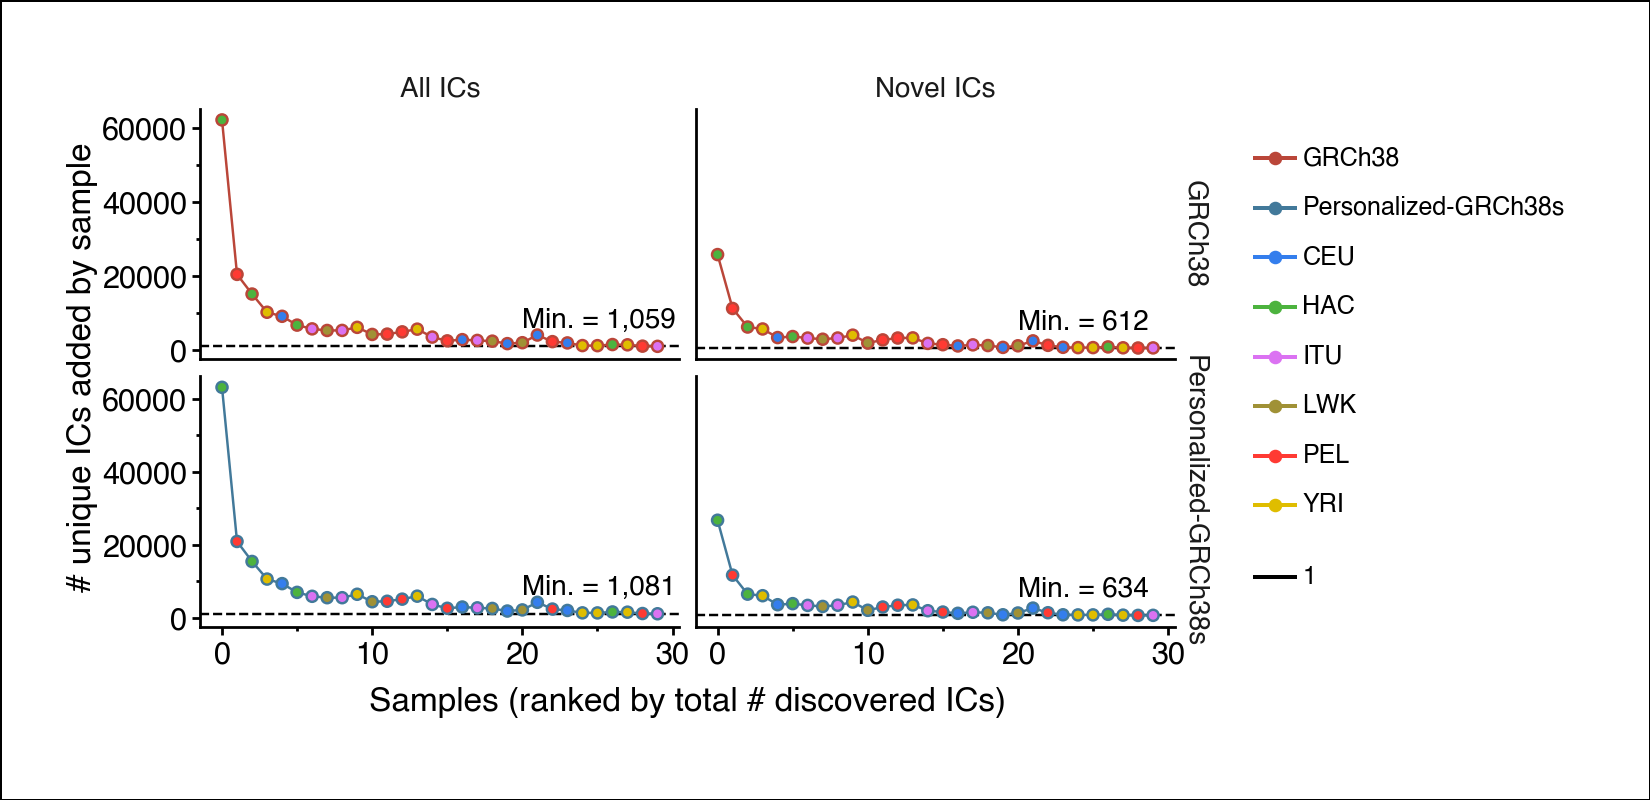

In [166]:
big_df_2.head()
big_df_2['nov_hr'] = big_df_2.ic_nov.map({'all': 'All ICs', 'nov': 'Novel ICs'})
big_df_2['gen_hr'] = big_df_2.genome.map({'hg38': 'GRCh38', 'pers': 'Personalized-GRCh38s'})


big_color_dict = p_c_dict
big_color_dict['GRCh38'] = '#ba4639'
big_color_dict['Personalized-GRCh38s'] = '#42799a'

big_df_2['min'] = big_df_2.groupby(['genome', 'ic_nov'])['n_added_uniq'].transform('min')
big_df_2['min_label'] = 'Min. = '+big_df_2['min'].map(lambda v: f'{v:,}').astype(str)

# Create summary df with one row per facet for horizontal line and label placement
min_df = big_df_2.groupby(['gen_hr', 'nov_hr']).agg(
    min_val=('min', 'first'),
    min_label=('min_label', 'first'),
    x_pos=('n_samples', 'max')
).reset_index()


(
    ggplot(big_df_2, aes(x='n_samples', y='n_added_uniq', color='gen_hr'))
    + geom_hline(
        data=min_df,
        mapping=aes(yintercept='min_val'),
        linetype='dashed',
        color='black',
        size=0.5
    )
    + geom_text(
        data=min_df,
        mapping=aes(x='x_pos', y='min_val', label='min_label'),
        ha='left',
        va='bottom',
        nudge_x=-9,
        nudge_y=3500,
        size=10,
        inherit_aes=False
    )
    + geom_line(aes(color='gen_hr', width=0.25, alpha=1))
    + geom_point(aes(color='gen_hr'), size=1.75)
    + geom_point(aes(color='population'), size=0.75)
    + scale_color_manual(values=big_color_dict)

    + labs(
        x='Samples (ranked by total # discovered ICs)',
        y='# unique ICs added by sample'
    )
    + facet_grid('gen_hr ~ nov_hr', scales='free_y')
    + my_theme(w=8.25, h=4)

)

## Now cumulative

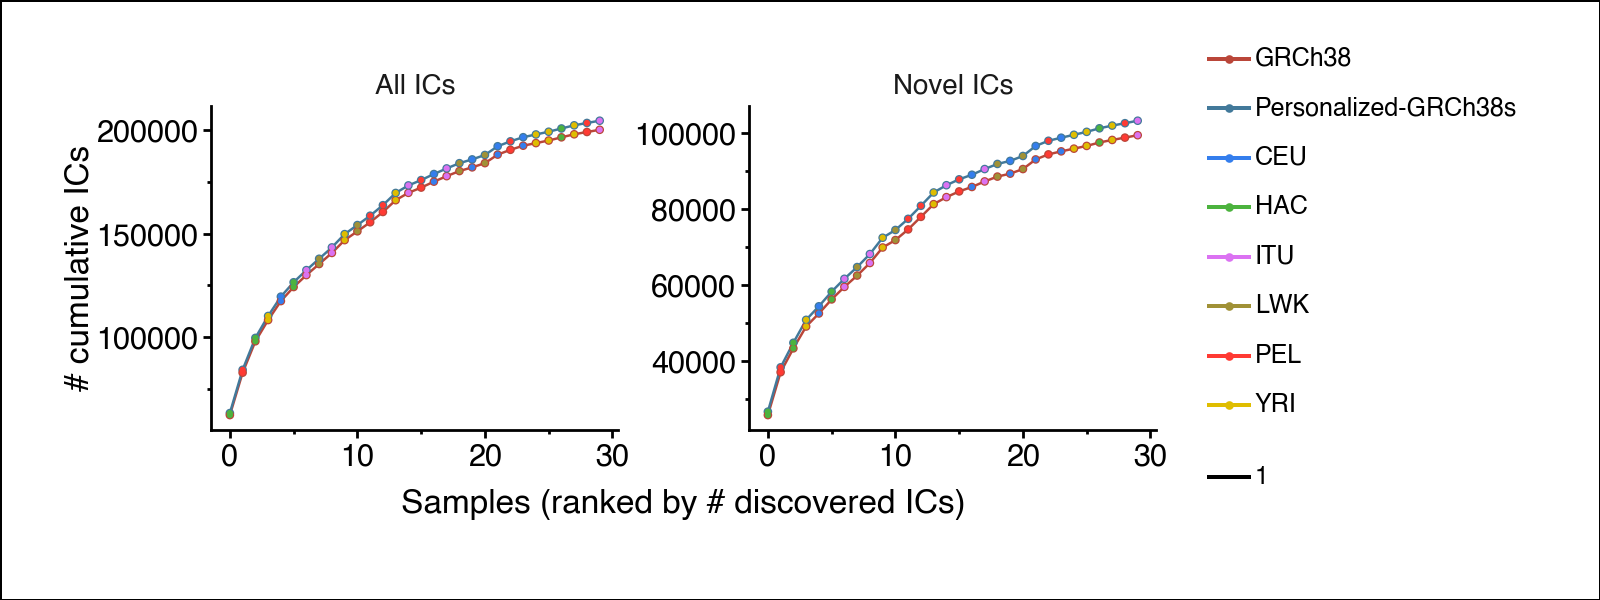

In [168]:


(
    ggplot(big_df_2, aes(x='n_samples', y='n_cumulative_ics', color='gen_hr'))
    + geom_line(aes(color='gen_hr', width=0.5, alpha=1))
    + geom_point(aes(color='gen_hr'), size=0.75)
    + geom_point(aes(color='population'), size=0.25)
    + scale_color_manual(values=big_color_dict)
    + labs(
        x='Samples (ranked by # discovered ICs)',
        y='# cumulative ICs'
    )
    + facet_wrap('~nov_hr',
                 ncol=len(big_df_2.nov_hr.unique().tolist()),
                 scales='free_y')

    + my_theme(w=8, h=3)
    # + theme(legend_position='none')
)



## Now get the difference between personal - hg38 for each step

In [170]:
hg38_df = big_df_2.loc[big_df_2.genome=='hg38']
pers_df = big_df_2.loc[big_df_2.genome=='pers']

print(len(big_df_2.index))
big_df_3 = hg38_df.merge(pers_df, 
                         how='outer',
                         on=['n_samples', 
                             'population',
                             'cell_line_id_1000g',
                             'ic_nov','nov_hr'],
                         suffixes=('_hg38', '_pers'))
print(len(big_df_3.index))

120
60


In [173]:
big_df_3['pers_minus_hg38_diff'] = big_df_3['n_added_uniq_pers'] - big_df_3['n_added_uniq_hg38']

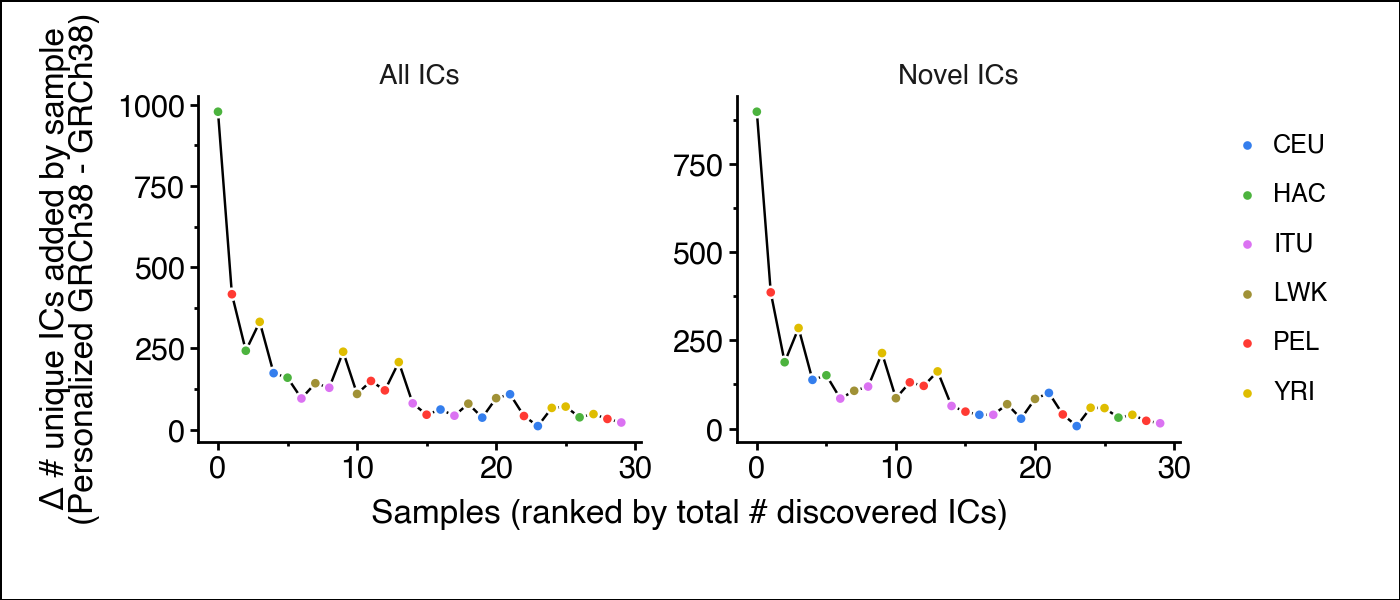

In [183]:
big_df_2['min'] = big_df_2.groupby(['genome', 'ic_nov'])['n_added_uniq'].transform('min')
big_df_2['min_label'] = 'Min. = '+big_df_2['min'].map(lambda v: f'{v:,}').astype(str)

# Create summary df with one row per facet for horizontal line and label placement
min_df = big_df_2.groupby(['gen_hr', 'nov_hr']).agg(
    min_val=('min', 'first'),
    min_label=('min_label', 'first'),
    x_pos=('n_samples', 'max')
).reset_index()


(
    ggplot(big_df_2, aes(x='n_samples', y='n_added_uniq', color='gen_hr'))
    + geom_hline(
        data=min_df,
        mapping=aes(yintercept='min_val'),
        linetype='dashed',
        color='black',
        size=0.5
    )
    + geom_text(
        data=min_df,
        mapping=aes(x='x_pos', y='min_val', label='min_label'),
        ha='left',
        va='bottom',
        nudge_x=-9,
        nudge_y=3500,
        size=10,
        inherit_aes=False
    )

(
    ggplot(big_df_3, aes(x='n_samples', y='pers_minus_hg38_diff'))
    + geom_line()
    + geom_point(color='white', size=1.75)
    + geom_point(aes(color='population'), size=0.75)
    + scale_color_manual(values=big_color_dict)
    + facet_wrap('~nov_hr',
                 ncol=len(big_df_3.nov_hr.unique().tolist()),
                 scales='free_y')
    + labs(
        x='Samples (ranked by total # discovered ICs)',
        y=f'\u0394 # unique ICs added by sample\n(Personalized GRCh38 - GRCh38)'
    )
    + my_theme(w=7, h=3)

)